# Load modules

In [3]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle # For rectangles
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
from scipy import stats # For linregress (trends)
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, '../../../') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
u.check_virtual_memory()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
3.8.2 | packaged by conda-forge | (default, Feb 28 2020, 17:15:22) 
[GCC 7.3.0]
Virtual memory usage - total: 252 GB / available: 214 GB / percent used: 14.9 %


# Load model data

In [4]:
# Define period
period = slice('1981','2014')

# Define zone
latlim=(10,50)
lonlim=(60,110)

# Model
institute = 'IPSL'
model = 'IPSL-CM6A-LR'
season='DJFMA'

# Check the differences between ERA-Interim and model for Near-Surface Air Temperature

## Load first member

In [5]:
realization = 'r1i1p1f1'
var = 'tas'
table = 'Amon'

# Load historical
tas = xr.open_mfdataset(
    '/bdd/CMIP6/CMIP/'+institute+'/'+model+'/historical/'+realization+'/'+table+'/'+var+'/gr/latest/*.nc', 
    combine='by_coords'
).sel(time=period)[var]-273.15

# ERA-Interim
tas_era = xr.open_mfdataset(
    '/bdd/ERAI/NETCDF/GLOBAL_075/1xmonthly/AN_SF/*/t2.*.asmei.GLOBAL_075.nc',
    combine='by_coords', parallel=True
).t2.sel(time=period).load()-273.15

## Regrid

In [6]:
regridder = xe.Regridder(tas_era, tas, 'bilinear', periodic=True, reuse_weights=True)
tas_era_regrid = regridder(tas_era)

Reuse existing file: bilinear_241x480_143x144_peri.nc


## Compute clim

In [7]:
tas_clim = u.custom_season_clim(tas, season=season)
tas_era_regrid_clim = u.custom_season_clim(tas_era_regrid, season=season)

In [8]:
tas_bias = tas_clim-tas_era_regrid_clim

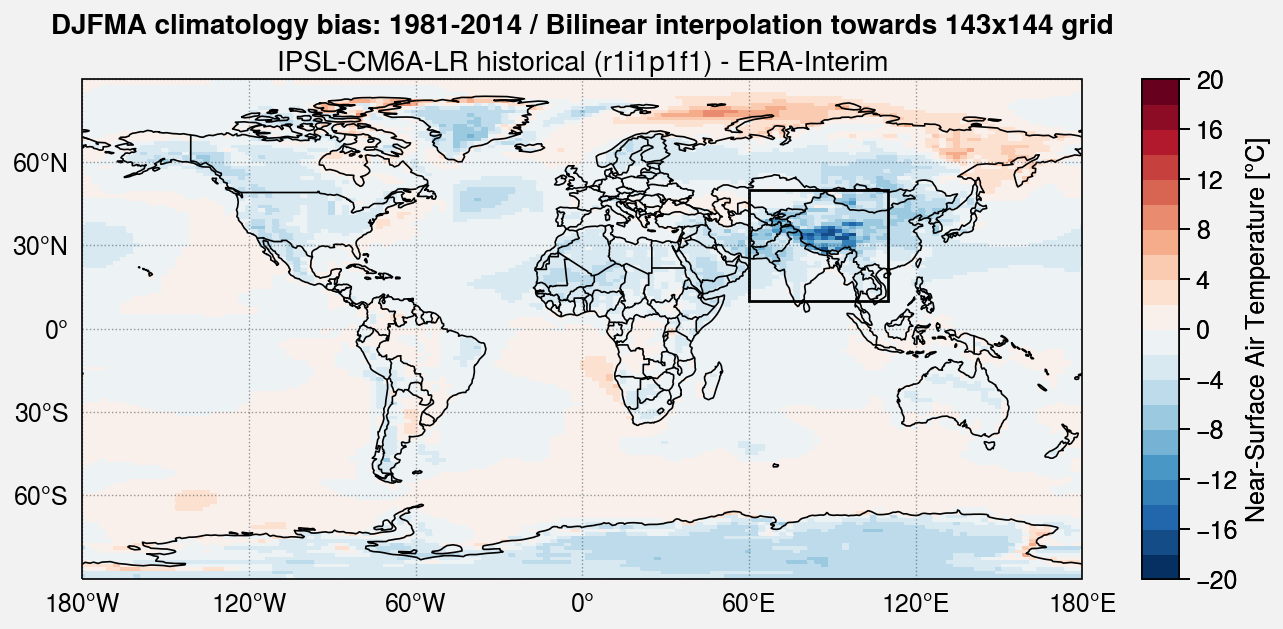

In [10]:
import matplotlib.patches as mpatches
import cartopy.crs as ccrs

dx=2.5
dy=1.2676

f, axs = plot.subplots(proj='cyl', ncols=1, nrows=1, axwidth=5)

m = axs[0].pcolormesh(tas_bias, cmap='RdBu_r', levels=plot.arange(-20,20,2))
axs[0].format(title='IPSL-CM6A-LR historical (r1i1p1f1) - ERA-Interim')

f.colorbar(m, label='Near-Surface Air Temperature [°C]')


# Add box   
axs[0].add_patch(mpatches.Rectangle(
    xy=[lonlim[0], latlim[0]], width=lonlim[1]-lonlim[0], height=latlim[1]-latlim[0],
    transform=ccrs.PlateCarree(), fill=False
))


axs.format(
    geogridlinewidth=0.5, geogridcolor='gray8', geogridalpha=0.5, labels=True, 
    coast=True, ocean=True, oceancolor='gray3', borders=True,
    suptitle=season+" climatology bias: 1981-2014 / Bilinear interpolation towards 143x144 grid",
    lonlines=60, latlines=30, abc=False
)

var = 'ta'
f.save('img/'+var+'/tas_IPSL_CMIP6-ERAI_bias_global_'+season+'.png')
f.save('img/'+var+'/tas_IPSL_CMIP6-ERAI_bias_global_'+season+'.pdf')

# Load surface pressure for masking ERA-Interim
http://clipc-services.ceda.ac.uk/dreq/u/8c9504d28596e05586c8e193082ac617.html

In [11]:
realization = 'r1i1p1f1'
var = 'ps'
table = 'Amon'

# Load historical
ps = xr.open_mfdataset(
    '/bdd/CMIP6/CMIP/'+institute+'/'+model+'/historical/'+realization+'/'+table+'/'+var+'/gr/latest/*.nc', 
    combine='by_coords'
).sel(time=period)[var]

# ERA-Interim
ps_era = xr.open_mfdataset(
    "/data/mlalande/ERAI/sp/sp_ERAI_*.nc",
    combine='by_coords', parallel=True
).sp.sel(time=period).load()

In [12]:
ps_era_regrid = regridder(ps_era)

# Get the minimum pressure (finally not used) -> finally mean for the season... easier
ps_min = u.custom_season_clim(ps, season=season)
ps_era_regrid_min = u.custom_season_clim(ps_era_regrid, season=season)

# Load Air Temperature

In [13]:
var ='ta'

ta = xr.open_mfdataset(
    '/bdd/CMIP6/CMIP/'+institute+'/'+model+'/historical/'+realization+'/'+table+'/'+var+'/gr/latest/*.nc', combine='by_coords', parallel=True
).sel(time=period)[var].load()-273.15

ta_era = xr.open_mfdataset(
    '/bdd/ERAI/NETCDF/GLOBAL_075/1xmonthly/AN_PL/*/ta.*.apmei.GLOBAL_075.nc',
    combine='by_coords', parallel=True
).ta.sel(time=period).load()-273.15

## Regrid horizontal

In [14]:
# Regrid horizontal
ta_era_regrid = regridder(ta_era)

## Mask vertical values > ps

In [15]:
ta_era_regrid_masked = ta_era_regrid.where(ta_era_regrid.level <= ps_era_regrid/100)

## Regrid vertical

In [16]:
ta_era_regrid_masked_v = ta_era_regrid_masked.interp(level=(ta.plev.values/100), method='linear')

## Compute climatologie

In [16]:
# ta_clim = ta.mean('time', skipna=False).load()
# ta_era_regrid_masked_clim = ta_era_regrid_masked.mean('time', skipna=False).load()
# ta_era_regrid_masked_v_clim = ta_era_regrid_masked_v.mean('time', skipna=False).load()

# ta_bias = ta_clim-ta_era_regrid_masked_v_clim.values

In [17]:
ta_clim = u.custom_season_clim(ta, season=season)
ta_era_regrid_masked_clim = u.custom_season_clim(ta_era_regrid_masked, season=season)
ta_era_regrid_masked_v_clim = u.custom_season_clim(ta_era_regrid_masked_v, season=season)

ta_bias = ta_clim-ta_era_regrid_masked_v_clim.values

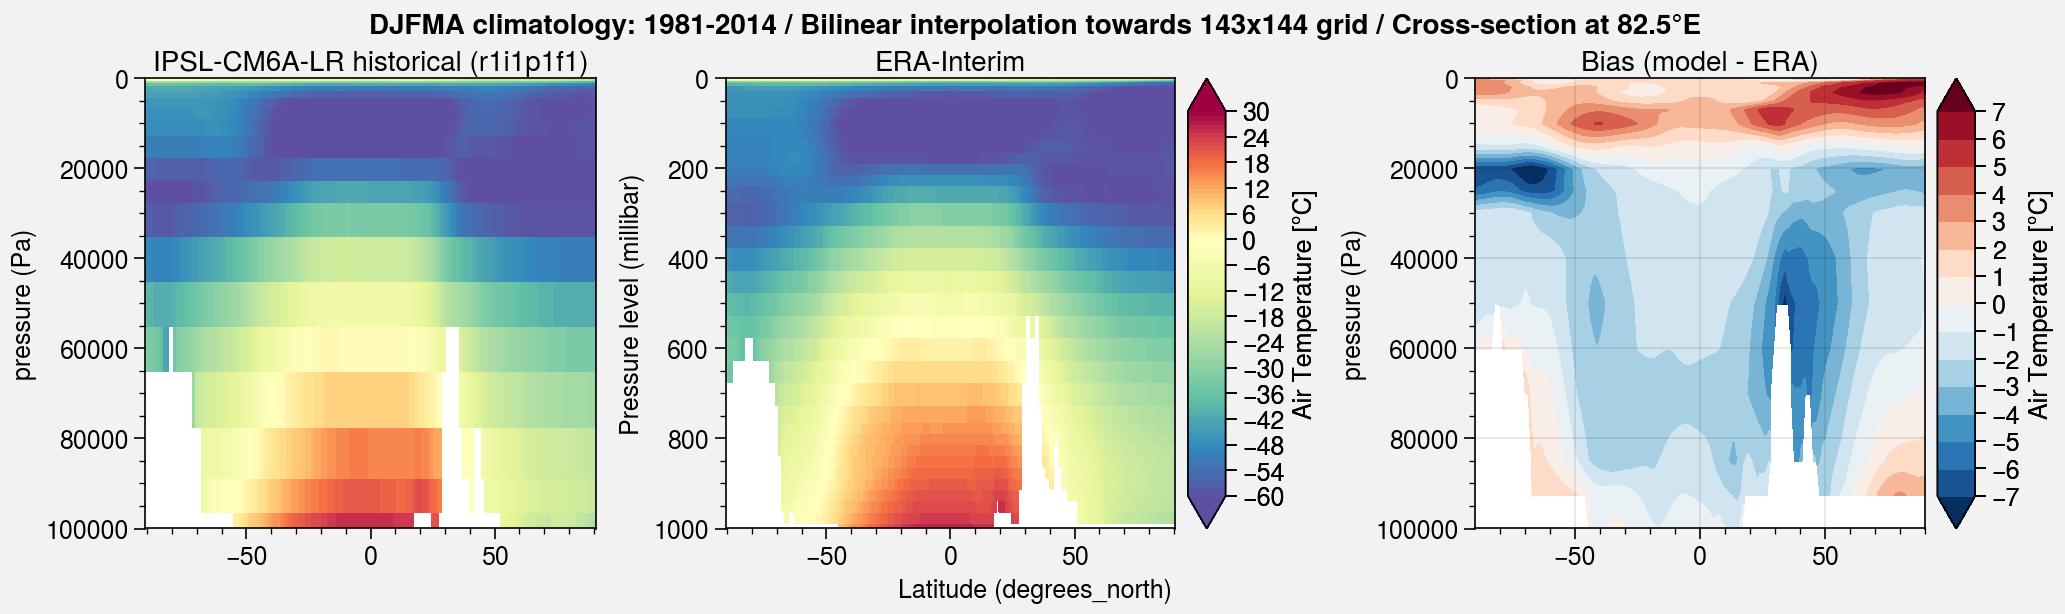

In [23]:
#Check colorbars 
levels = plot.arange(-60,30,1)
extend='both'
cmap='Spectral'

f, axs = plot.subplots(nrows=1, ncols=3, sharey=0)

# Model
m1 = axs[0].pcolormesh(ta_clim.sel(lon=82.5), cmap=cmap, levels=levels, norm='midpoint', extend=extend)
axs[0].format(ylim=(100000,0), title='IPSL-CM6A-LR historical (r1i1p1f1)')

# ERA-Interim
axs[1].pcolormesh(ta_era_regrid_masked_clim.sel(lon=82.5), cmap=cmap, levels=levels, norm='midpoint', extend=extend)
axs[1].format(ylim=(1000,0), title='ERA-Interim')
axs[1].colorbar(m1, label='Air Temperature [°C]')

# Bias
m2 = axs[2].contourf(ta_bias.sel(lon=82.5), cmap='BuRd', levels=plot.arange(-7,7,1), extend=extend)
axs[2].format(ylim=(100000,0), title='Bias (model - ERA)')
axs[2].colorbar(m2, label='Air Temperature [°C]')


axs.format(
    suptitle=season+" climatology: 1981-2014 / Bilinear interpolation towards 143x144 grid / Cross-section at 82.5°E"
)

f.save('img/ta/slice_lon_82_5_ta_pcolormesh_global_'+season+'.png')
f.save('img/ta/slice_lon_82_5_ta_pcolormesh_global_'+season+'.pdf')

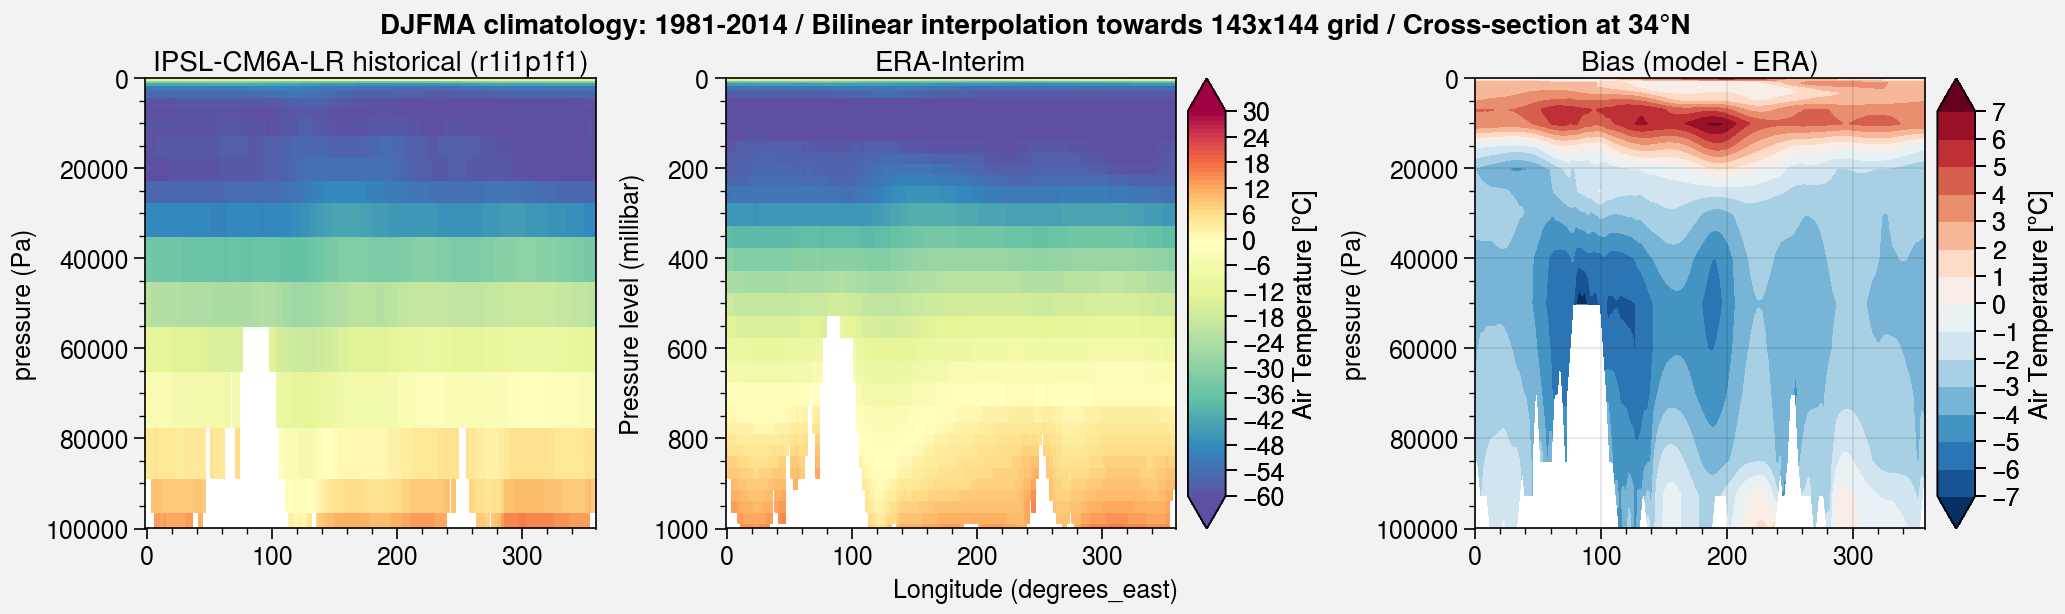

In [24]:
#Check colorbars 
levels = plot.arange(-60,30,1)
extend='both'
cmap='Spectral'

f, axs = plot.subplots(nrows=1, ncols=3, sharey=0)

# Model
m1 = axs[0].pcolormesh(ta_clim.sel(lat=34.225353), cmap=cmap, levels=levels, norm='midpoint', extend=extend)
axs[0].format(ylim=(100000,0), title='IPSL-CM6A-LR historical (r1i1p1f1)')

# ERA-Interim
axs[1].pcolormesh(ta_era_regrid_masked_clim.sel(lat=34.225353), cmap=cmap, levels=levels, norm='midpoint', extend=extend)
axs[1].format(ylim=(1000,0), title='ERA-Interim')
axs[1].colorbar(m1, label='Air Temperature [°C]')

# Bias
m2 = axs[2].contourf(ta_bias.sel(lat=34.225353), cmap='BuRd', levels=plot.arange(-7,7,1), extend=extend)
axs[2].format(ylim=(100000,0), title='Bias (model - ERA)')
axs[2].colorbar(m2, label='Air Temperature [°C]')


axs.format(
    suptitle=season+" climatology: 1981-2014 / Bilinear interpolation towards 143x144 grid / Cross-section at 34°N"
)

f.save('img/ta/slice_lat_34_ta_pcolormesh_global_'+season+'.png')
f.save('img/ta/slice_lat_34_ta_pcolormesh_global_'+season+'.pdf')

# Zonal and meridional mean global / HM / global-HM

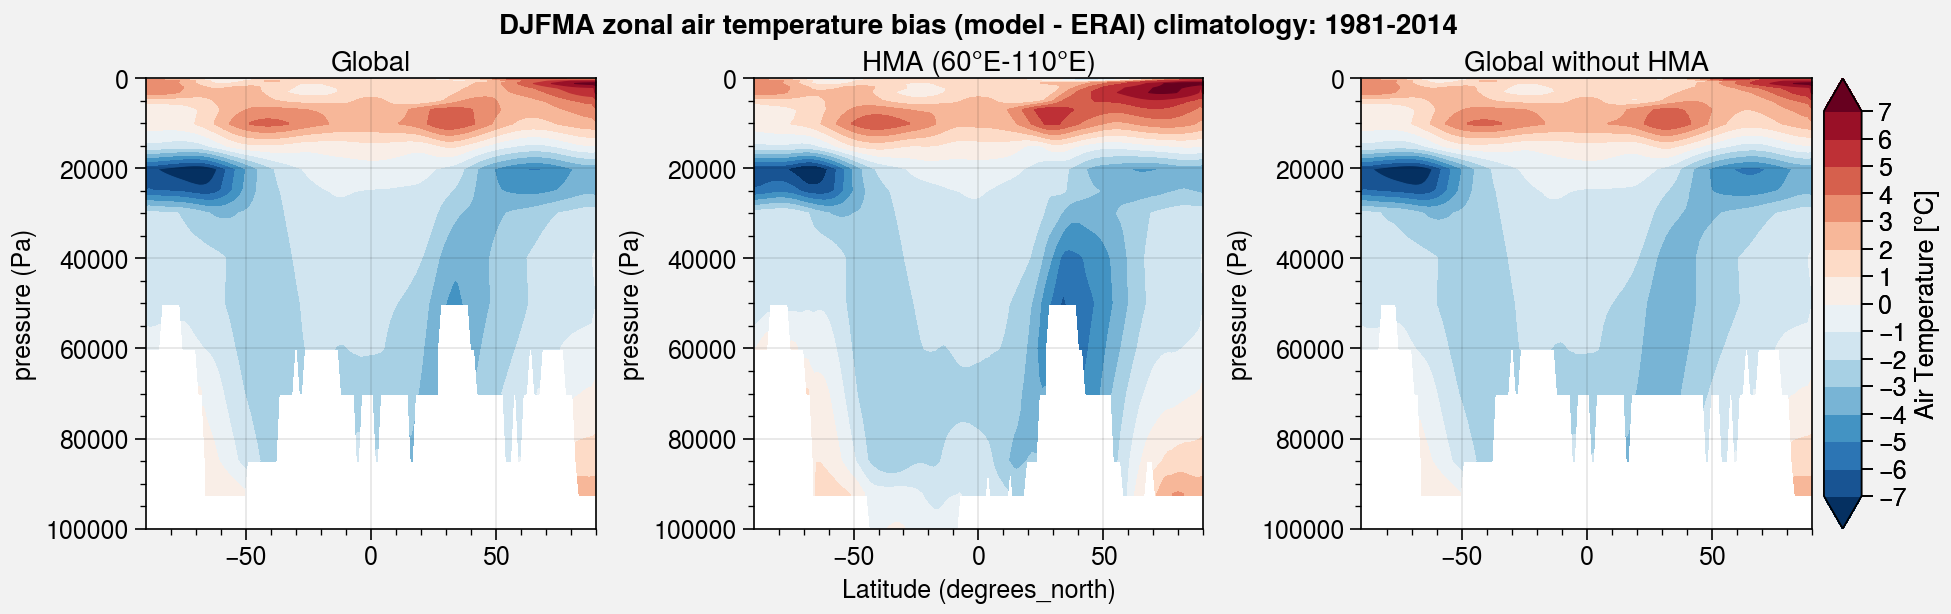

In [25]:
#Check colorbars 
levels=plot.arange(-7,7,1)
extend='both'
cmap='BuRd'

f, axs = plot.subplots(nrows=1, ncols=3, sharey=0)

# Model
axs[0].contourf(ta_bias.mean('lon', skipna=False), cmap=cmap, levels=levels, extend=extend)
axs[0].format(ylim=(100000,0), title='Global')

# ERA-Interim
axs[1].contourf(ta_bias.sel(lon=slice(lonlim[0],lonlim[1])).mean('lon', skipna=False), cmap=cmap, levels=levels, extend=extend)
axs[1].format(ylim=(100000,0), title='HMA (60°E-110°E)')

# Bias
m2 = axs[2].contourf(ta_bias.where((ta_bias.lon < 60) | (ta_bias.lon > 110), drop=True).mean('lon', skipna=False), cmap=cmap, levels=levels, extend=extend)
axs[2].format(ylim=(100000,0), title='Global without HMA')
axs[2].colorbar(m2, label='Air Temperature [°C]')


axs.format(
    suptitle=season+" zonal air temperature bias (model - ERAI) climatology: 1981-2014"
)

f.save('img/ta/zonal_ta_global_HMA_'+season+'.png')
f.save('img/ta/zonal_ta_global_HMA_'+season+'.pdf')